# DMW2 Lab 1: Clustering on Open Library Dataset

The Open Library dataset is a vast repository of bibliographic records, containing metadata for books from diverse languages, subjects, and publication periods. It includes key attributes such as titles, publish dates, languages, and subjects, making it a valuable resource for analyzing global literary trends.

This study focuses on East Asian literature, specifically books in Japanese (JPN), Korean (KOR), and Chinese (CHI). By leveraging Natural Language Processing (NLP) and machine learning techniques, we aim to uncover patterns in subjects, themes, and publication trends across these languages.

For this study, we outline three important sections:
1. Data Extraction and Preprocessing
2. Feature Engineering
3. Clustering

We will discuss each section as we go along.

In [39]:
import os
import gzip
import json
import isbnlib
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data_base_path = "../data/"

In [3]:
def read_txt(file_path, total_lines, valid_cols):
    """
    Reads a tab-separated text file and extracts JSON data from the fifth column, 
    filtering it based on valid column keys.

    Parameters
    ----------
    file_path : str
        Path to the input text file.
    total_lines : int
        Estimated total number of lines in the file (used for tqdm progress bar).
    valid_cols : list of str
        List of valid keys to extract from the JSON data.

    Returns
    -------
    dict
        A dictionary where each key is a line index and the value is a dictionary 
        containing the extracted JSON fields that match `valid_cols`.
    """
    df_dict = {}
    
    with open(file_path, "r", encoding="utf-8") as infile:
        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing lines")):
            # if idx > 10000:
            #     break
            parts = line.strip().split("\t")
            
            if len(parts) < 5:
                continue 

            try:
                json_data = json.loads(parts[4])
                
                for key in json_data.keys():
                    df_dict[idx] = {key: json_data.get(key, np.nan) for key in valid_cols if key in json_data}
                
            except json.JSONDecodeError:
                continue

    return df_dict

## Data Extraction and Preprocessing

### Dataset Overview
The Open Library dataset contains of tab-separated text files that are compressed containing metadata of books, authors, and editions. Each line in the dataset represents a single record, where the fifth item contains metadata in JSON format. We opted to focus on the editions dataset ONLY as we found it to have the most information available. Given the size of the dataset, we focused on recent publications (2016 and later). To save on memory, we delete each file after accessing it.

### Key Parameters and Processing
The function extracts the following key attributes:
- Book Metadata: `"key"`, `"works"`, `"title"`
- Publishing Information: `"publishers"`, `"publish_date"`, `"publish_country"`
- Content Information: `"description"`, `"first_sentence"`, `"subjects"`, `"languages"`
- Structural Information: `"number_of_pages"`, `"latest_revision"`, `"revision"`

We preselected these JSON keys as we had identified them to be the most relevant to our analysis.

In [4]:
!zgrep -E '"publish_date": "(20(1[6-9]|[2-9][0-9]))([^"]*)?"' /mnt/data/public/openlibrary/20221007/ol_dump_editions_latest.txt.gz > editions_after_2015.txt

In [5]:
extracted_files = {
    "editions": {
        "file_path": "editions_after_2015.txt",
        "total_lines": 4259552,
    },
    "works": {
        "file_path": "filtered_works_with_editions.txt",
        "total_lines": 909883,
    },
    "authors": {
        "file_path": "filtered_authors_with_works_and_editions.txt",
        "total_lines": 853086,
    }
}

In [6]:
record_type = "editions"

ed_cols = [
    "key", "works", "title", "publishers", "description", "first_sentence", "subjects", "languages",
    "publish_date", "publish_country", "number_of_pages", "latest_revision", "revision"
]

file_path, total_lines = extracted_files[record_type]["file_path"], extracted_files[record_type]["total_lines"]
editions_dict = read_txt(file_path, total_lines, ed_cols)

Processing lines: 100%|██████████| 4259552/4259552 [06:56<00:00, 10234.65it/s]


In [7]:
!rm editions_after_2015.txt

### Data Cleaning

In this step, we preprocess and clean the Open Library Editions dataset to ensure high-quality data for further analysis. The main objectives of this code are to remove highly incomplete columns, standardize key fields, and filter out records with insufficient data.

#### Handling Missing Values
We first assessed the proportion of missing values across all columns in the dataset. We set the condition for dropping columns with more than 70% missing values. We found that this greatly reduced our dataset but improved quality.

#### Handling Specific Columns
**Publish Year**
- Extracts the first four characters (YYYY) from publish_date and converts them into integers.
- This ensures a numeric representation of the publish year for better analysis.

**Formatting Subjects**
- If a book has multiple subjects (stored as a list), they are joined into a single string separated by commas.
- This makes the subjects column easier to process in text-based analysis (e.g., TF-IDF).

**Standardizing Language Codes**
- The language information is stored as a list of dictionaries (e.g., `[{"key": "/languages/eng"}]`).
- This extracts the ISO language code (e.g., "eng", "jpn", "kor", "chi") for consistency.

**Removing Incomplete Entries**
- Any rows missing key fields (`title`, `languages`, `subjects`) are removed.
- The cleaned dataset is saved as `final_editions_df`.

In [8]:
editions_df = pd.DataFrame.from_dict(editions_dict, orient="index")
editions_df.head()

,key,works,title,publishers,description,publish_date,number_of_pages,latest_revision,revision,languages,subjects,publish_country,first_sentence
0,/books/OL24367788M,[{'key': '/works/OL15386091W'}],Akademia Canterwood: Wysokie Aspiracje,[PUBLICAT S. A.],"{'type': '/type/text', 'value': 'W elitarnym g...",2016,213.0,5.0,5,NaN,NaN,NaN,NaN
1,/books/OL25896697M,[{'key': '/works/OL17321171W'}],Too Blessed to Be Stressed,[Barbour],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN
2,/books/OL25896725M,[{'key': '/works/OL17321197W'}],"Fuera llueve, dentro también, ¿paso a buscarte?",[Montena],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
3,/books/OL25898027M,[{'key': '/works/OL17322236W'}],Satin Island,[Pálido Fuego],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
4,/books/OL25898429M,[{'key': '/works/OL17322587W'}],La península de Cilemaga,[Pregunta Ediciones],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN


In [9]:
del editions_dict

In [10]:
editions_df.shape

(4259552, 13)

In [11]:
editions_df.isna().sum() / len(editions_df) * 100

key                 0.000000
works               0.000610
title               0.000916
publishers          1.484264
description        98.352033
publish_date        0.000000
number_of_pages    70.451071
latest_revision     0.000047
revision            0.000000
languages           1.504712
subjects           69.716768
publish_country    97.697199
first_sentence     99.977556
dtype: float64

In [12]:
final_cols = ["key", "works", "title", "publishers", "publish_date", "languages", "subjects"]

drp_df = editions_df[final_cols]
del editions_df

In [13]:
drp_df["publishers"] = drp_df["publishers"].str[0]
drp_df["publishers"].fillna("Self-published", inplace=True)
drp_df["publish_year"] = ([int(x[:4]) for x in drp_df["publish_date"]])
drp_df["subjects"] = drp_df["subjects"].str.join(" ")
drp_df["works"] = drp_df["works"].apply(lambda x: x[0]["key"] if isinstance(x, list) and x else None)
drp_df["languages"] = drp_df["languages"].apply(
    lambda x: x[0]["key"].split("/")[-1] if isinstance(x, list) and x and "key" in x[0] else np.nan
)

final_editions_df = drp_df.dropna(subset=["title", "languages", "subjects"])

del drp_df

In [14]:
final_editions_df

,key,works,title,publishers,publish_date,languages,subjects,publish_year
67,/books/OL26450333M,/works/OL17868105W,West of Eden,Self-published,2016,eng,Social life and customs PERFORMING ARTS Histor...,2016
72,/books/OL26453406M,/works/OL17872089W,What you always wanted,Self-published,2016,eng,JUVENILE FICTION / Social Themes / Friendship ...,2016
82,/books/OL26474165M,/works/OL17897021W,The Kentucky cowboy's baby,Harlequin Books,2016,eng,Fiction Ranches Man-woman relationships Physic...,2016
87,/books/OL26487791M,/works/OL17912752W,Breakthrough,Self-published,2016,eng,Women presidents Women politicians Kvinnliga p...,2016
112,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,2016,chi,Zhang pian xiao shuo Er tong wen xue,2016
...,...,...,...,...,...,...,...,...
4259502,/books/OL39784786M,/works/OL28903893W,Abby's Pony Love,Hastings Creations Group,2022,eng,Children's fiction Pets,2022
4259516,/books/OL39786866M,/works/OL28852046W,Fea,KV Books LLC,2022,eng,"Fiction, lgbtq+, gay Fiction, general",2022
4259540,/books/OL39791850M,/works/OL28939362W,Sketch Tour of Yale University,Joseph Merritt Company,2022,eng,Architecture Art,2022
4259548,/books/OL39793914M,/works/OL28909366W,Is for Alexander,History Unboxed,2022,eng,Biography World history,2022


In [15]:
final_editions_df.dtypes

key             object
works           object
title           object
publishers      object
publish_date    object
languages       object
subjects        object
publish_year     int64
dtype: object

In [16]:
final_editions_df.languages.value_counts()

languages
eng    1238882
ger      11544
spa      10917
chi       8785
fre       4815
        ...   
nyn          1
nic          1
lin          1
gmh          1
tet          1
Name: count, Length: 152, dtype: int64

### EDA

In [17]:
east_asian_editions_df = final_editions_df[final_editions_df["languages"].isin(["jpn", "kor", "chi"])].drop("publish_date", axis=1)
east_asian_editions_df

,key,works,title,publishers,languages,subjects,publish_year
112,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,chi,Zhang pian xiao shuo Er tong wen xue,2016
133,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,chi,Television mini-series Chinese Television plays,2017
139,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,chi,Chinese essays Anecdotes,2017
148,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,chi,Slow Electric cooking Casserole cooking Intern...,2017
149,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,chi,Alternative treatment Recipes Constipation Die...,2016
...,...,...,...,...,...,...,...
4248088,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,chi,"Labor laws and legislation, china Labor contra...",2016
4252711,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,chi,Yi dong zhong duan Ying yong cheng xu Cheng xu...,2016
4252719,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,chi,Gao deng shu xue Sheng xue can kao zi liao Shu...,2016
4254893,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,chi,Zhang pian xiao shuo,2016


In [18]:
del final_editions_df

In [19]:
east_asian_editions_df[east_asian_editions_df["key"]=="/books/OL37824312M"]

,key,works,title,publishers,languages,subjects,publish_year
4238208,/books/OL37824312M,/works/OL27719558W,Tang shiSong ci san bai shou,Bei jing lian he chu ban gong si,chi,Tang shi Shi ji Song ci Xuan ji,2016


In [20]:
east_asian_editions_df.shape

(11949, 7)

In [21]:
east_asian_editions_df.groupby("languages")["key"].nunique()

languages
chi    8785
jpn    2483
kor     681
Name: key, dtype: int64

In [22]:
east_asian_editions_df.reset_index(inplace=True)
east_asian_editions_df.drop("index", axis=1, inplace=True)

east_asian_editions_df

,key,works,title,publishers,languages,subjects,publish_year
0,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,chi,Zhang pian xiao shuo Er tong wen xue,2016
1,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,chi,Television mini-series Chinese Television plays,2017
2,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,chi,Chinese essays Anecdotes,2017
3,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,chi,Slow Electric cooking Casserole cooking Intern...,2017
4,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,chi,Alternative treatment Recipes Constipation Die...,2016
...,...,...,...,...,...,...,...
11944,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,chi,"Labor laws and legislation, china Labor contra...",2016
11945,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,chi,Yi dong zhong duan Ying yong cheng xu Cheng xu...,2016
11946,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,chi,Gao deng shu xue Sheng xue can kao zi liao Shu...,2016
11947,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,chi,Zhang pian xiao shuo,2016


## Feature Engineering
This feature engineering pipeline prepares East Asian literary editions (Chinese, Japanese, and Korean) from the Open Library dataset for clustering analysis. The process includes text preprocessing, stopword removal, TF-IDF vectorization, dimensionality reduction, and feature scaling to create a structured numerical dataset.

### Stopword Removal
Given the scope of the dataset (East Asian literature), the Open Library dataset contained Romanized versions of Chinese, Japanese, and Korean text and we needed to account for Romanized forms during stopword removal. We utilized ChatGPT to come up with Romanized stopwords of the three languages.

### One-Hot Encoding for Language Feature
- Converts language labels (`chi`, `jpn`, `kor`) into separate binary columns (`languages_chi`, `languages_jpn`, `languages_kor`).
- Ensures the model treats languages as independent features.

### TF-IDF Vectorization for Subjects
- Converts text into numerical vectors based on word importance.
- Limits features to 5,000 words to reduce sparsity.

### Dimensionality Reduction Using Truncated SVD
- Applies Truncated Singular Value Decomposition (SVD) to reduce dimensionality.
- Determines the number of components needed to retain 90% of variance

### Standardization of Features
- Ensures all features have zero mean and unit variance.
- Prevents bias from large numerical differences.

The final, numerical dataset now consists of metadata (year, language) and text-based features (TF-IDF matrix))

### Without stopwords

In [ ]:
nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
japanese_stopwords = {"no", "wa", "wo", "ga", "to", "de", "kekkon"}
korean_stopwords = {"ŭl", "rŭl", "nŭn", "i", "ga", "e", "eseo", "yuga"}
chinese_stopwords = {"de", "shi", "zai", "you", "ta", "cheng", "xu"}


def remove_stopwords(text, lang):
    words = text.lower().split()
    
    if lang == "chi":  # Chinese stopword removal
        words = [word for word in words if word not in chinese_stopwords]
    elif lang == "jpn":  # Japanese stopword removal
        words = [word for word in words if word not in japanese_stopwords]
    elif lang == "kor":  # Korean stopword removal
        words = [word for word in words if word not in korean_stopwords]
    elif lang == "eng":  # English stopword removal
        words = [word for word in words if word not in english_stopwords]
    
    return " ".join(words)

east_asian_editions_df["text"] = east_asian_editions_df["title"] + " " + east_asian_editions_df["subjects"]
east_asian_editions_df["stopwordsless"] = east_asian_editions_df.apply(lambda row: remove_stopwords(row["text"], row["languages"]), axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2025/acastillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
lang_encoded = encoder.fit_transform(east_asian_editions_df[["languages"]])
lang_df = pd.DataFrame(lang_encoded, columns=encoder.get_feature_names_out(["languages"]))
df_encoded = pd.concat([east_asian_editions_df, lang_df], axis=1)

vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r"\b\w+\b")

tfidf_matrix = vectorizer.fit_transform(df_encoded["stopwordsless"])

svd = TruncatedSVD(n_components=min(tfidf_matrix.shape) - 1)
X_svd = svd.fit_transform(tfidf_matrix)

explained_variance = np.cumsum(svd.explained_variance_ratio_)
n_components = np.searchsorted(explained_variance, 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)

X_final = pd.DataFrame(X_svd, columns=[f"SV {i+1}" for i in range(X_svd.shape[1])])
X_final[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]] = df_encoded[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]]

scaler = StandardScaler()
X_scaled_stopwords = scaler.fit_transform(X_final)

Number of components to retain 90% variance: 1263


## Clustering

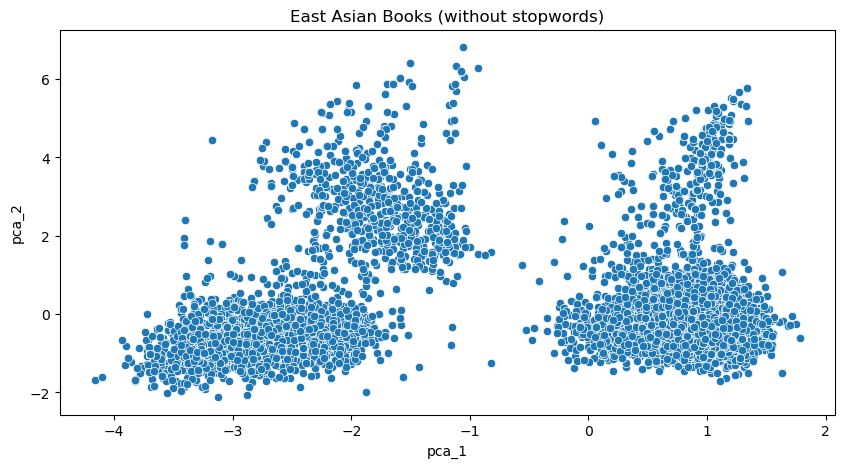

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled_stopwords)

df_encoded["pca_1"] = pca_result[:, 0]
df_encoded["pca_2"] = pca_result[:, 1]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], palette="viridis")
plt.title("East Asian Books (without stopwords)")
plt.show()

### KMeans

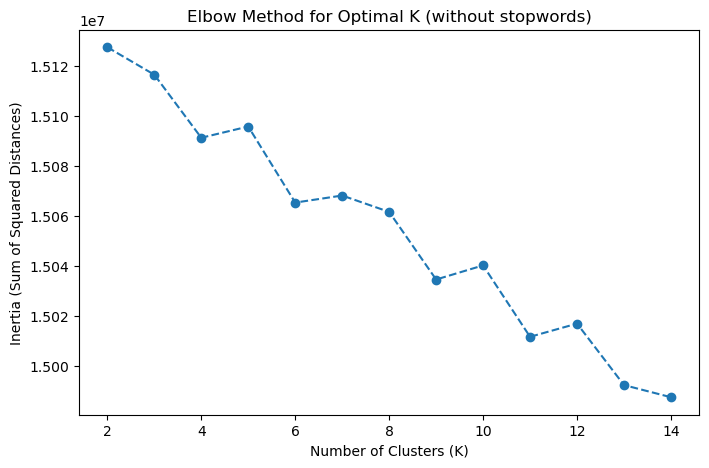

In [ ]:
inertia_values = []
k_range = range(2, 15)  # Testing clusters from 2 to 14

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_stopwords)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K (without stopwords)")
plt.show()

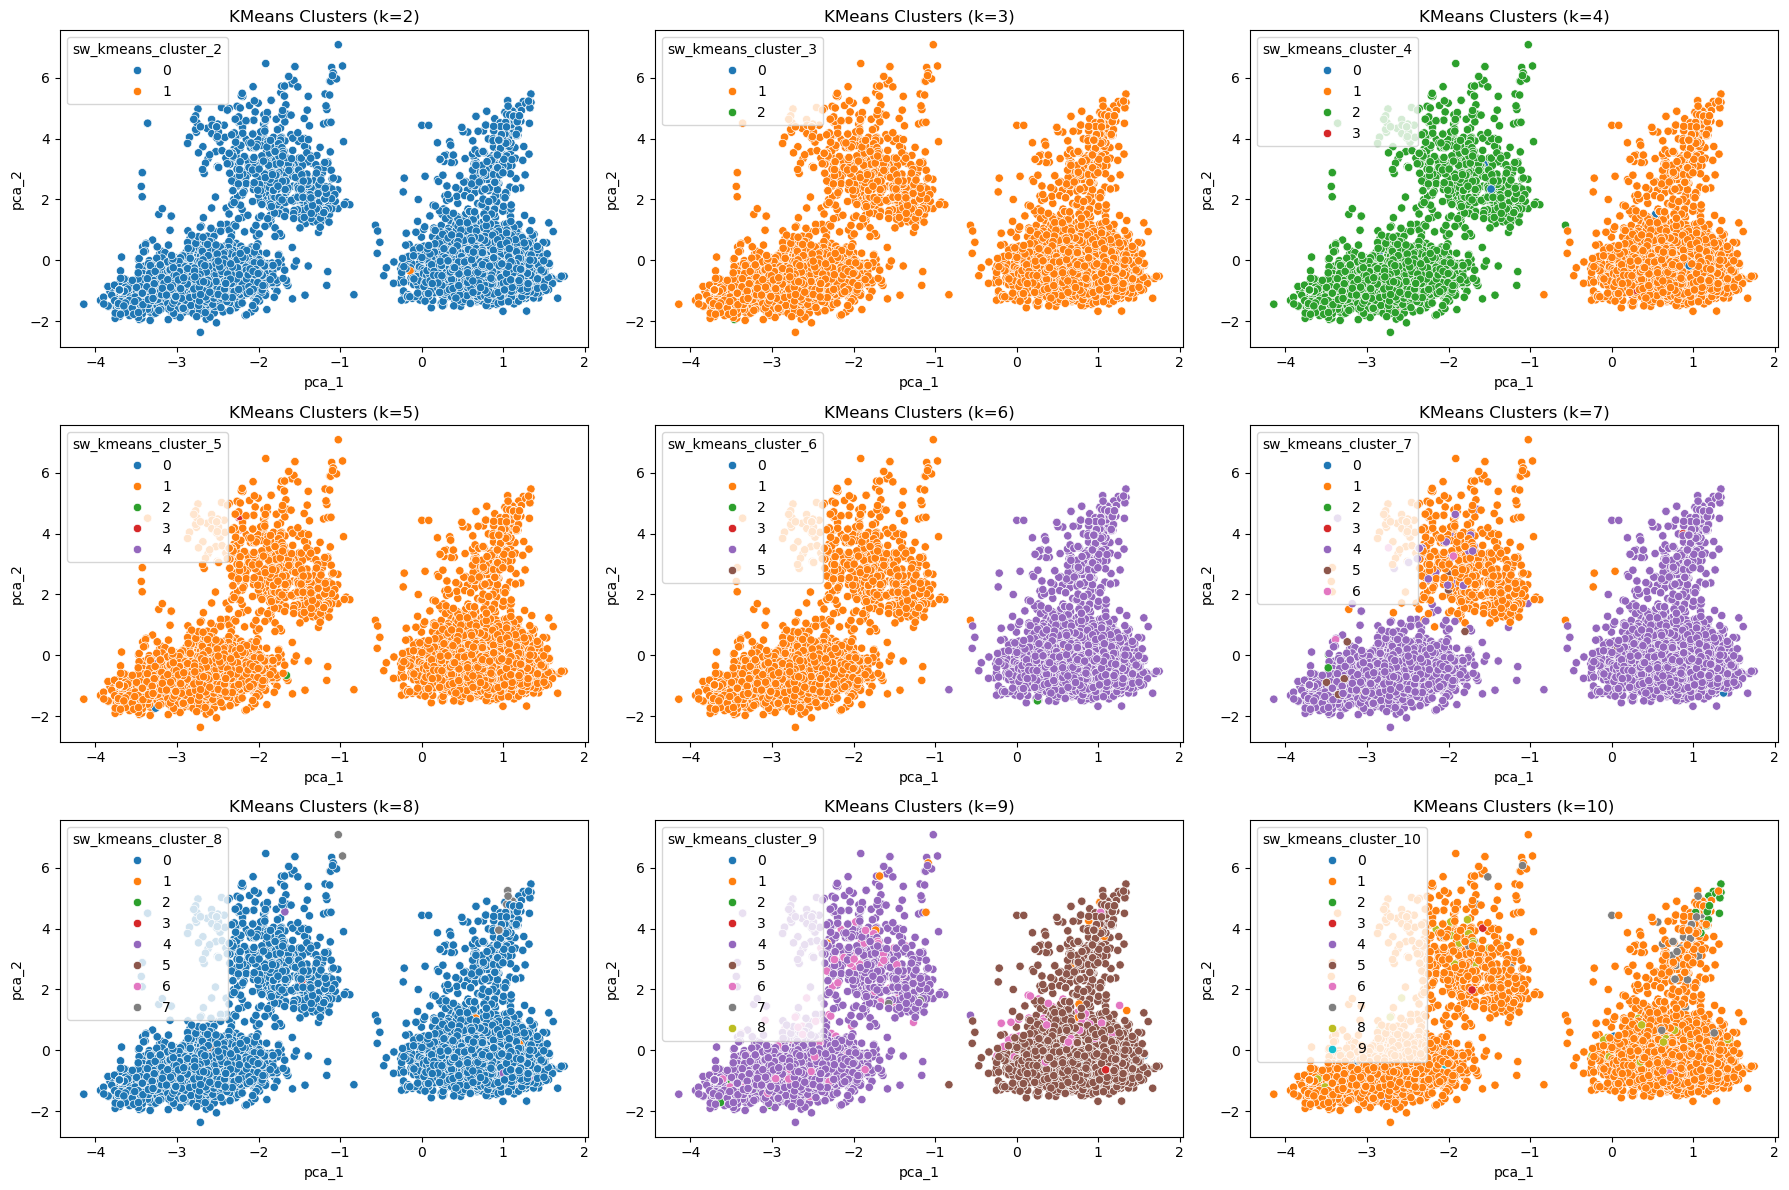

In [ ]:
k_range = range(2, 11)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_encoded[f"sw_kmeans_cluster_{k}"] = kmeans.fit_predict(X_scaled_stopwords)

    sns.scatterplot(
        x=df_encoded["pca_1"],
        y=df_encoded["pca_2"],
        hue=df_encoded[f"sw_kmeans_cluster_{k}"],
        palette="tab10",
        ax=axes[i]
    )
    
    axes[i].set_title(f"KMeans Clusters (k={k})")

plt.tight_layout()
plt.show()

df_encoded.groupby(["sw_kmeans_cluster_4", "languages"])["key"].nunique()

#### KMeans with `k=4`

In [45]:
df_encoded["sw_kmeans_cluster_4"].value_counts()

sw_kmeans_cluster_4
1    8772
2    3155
0      19
3       3
Name: count, dtype: int64

In [46]:
df_encoded.groupby(["sw_kmeans_cluster_4", "languages"])["key"].nunique()

sw_kmeans_cluster_4  languages
0                    chi            11
                     jpn             1
                     kor             7
1                    chi          8772
2                    jpn          2481
                     kor           674
3                    chi             2
                     jpn             1
Name: key, dtype: int64

Note: cluster 1 only has chinese, cluster 2 jpn and kor only. interesting. spin this pls

### Appendix: DBSCAN and Agglomerative Clustering

In [ ]:
dbscan = DBSCAN(eps=10, min_samples=5, metric='euclidean')  # Adjust eps & min_samples based on dataset
df_encoded["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

print("DBSCAN Cluster Counts:")
print(df_encoded["dbscan_cluster"].value_counts())

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=6, linkage="ward")
df_encoded["hierarchical_cluster"] = hierarchical.fit_predict(X_scaled)

print("Hierarchical Cluster Counts:")
print(df_encoded["hierarchical_cluster"].value_counts())\

In [ ]:
# DBSCAN Scatterplot
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], hue=df_encoded["dbscan_cluster"], palette="viridis")
plt.title("DBSCAN Clusters (Projected with PCA)")
plt.show()

# Hierarchical Clustering Scatterplot
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], hue=df_encoded["hierarchical_cluster"], palette="tab10")
plt.title("Hierarchical Clusters (Projected with PCA)")
plt.show()

## Disclaimer
Some parts of the markdown write up were generated using ChatGPT